In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sentencepiece as spm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

2023-08-24 01:36:23.145342: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
LATENT_DIM = 128
EMBEDDING_DIM = 100

In [3]:
df = pd.read_csv('https://github.com/ironmanciti/NLP_Lecture/raw/master/data/ChatbotData.csv')
df

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [5]:
df.iloc[:, [0, 1]].values

array([['12시 땡!', '하루가 또 가네요.'],
       ['1지망 학교 떨어졌어', '위로해 드립니다.'],
       ['3박4일 놀러가고 싶다', '여행은 언제나 좋죠.'],
       ...,
       ['흑기사 해주는 짝남.', '설렜겠어요.'],
       ['힘든 연애 좋은 연애라는게 무슨 차이일까?', '잘 헤어질 수 있는 사이 여부인 거 같아요.'],
       ['힘들어서 결혼할까봐', '도피성 결혼은 하지 않길 바라요.']], dtype=object)

In [6]:
q_texts = []
a_texts = []
for q, a in df.iloc[:, [0, 1]].values:
    q_texts.append(q)
    a_texts.append(a)
all_texts = q_texts + a_texts

len(all_texts), len(q_texts), len(a_texts)

(23646, 11823, 11823)

In [7]:
print(q_texts[:5])
print(a_texts[:5])

['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요.', '위로해 드립니다.', '여행은 언제나 좋죠.', '여행은 언제나 좋죠.', '눈살이 찌푸려지죠.']


In [8]:
with open('data/chatbot_qna.txt', 'w', encoding='utf-8') as f:
    for line in all_texts:
        f.write(line + '\n')

In [9]:
input_ = 'data/chatbot_qna.txt'
model_prefix = 'chatbot_qna'
vocab_size = 5000
pad_id = 0
bos_id = 1
eos_id = 2
unk_id = 3

cmd = f'--input={input_} \
        --model_prefix={model_prefix} \
        --vocab_size={vocab_size} \
        --pad_id={pad_id} \
        --bos_id={bos_id} \
        --eos_id={eos_id} \
        --unk_id={unk_id}'

spm.SentencePieceTrainer.Train(cmd)

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=data/chatbot_qna.txt         --model_prefix=chatbot_qna         --vocab_size=5000         --pad_id=0         --bos_id=1         --eos_id=2         --unk_id=3
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/chatbot_qna.txt
  input_format: 
  model_prefix: chatbot_qna
  model_type: UNIGRAM
  vocab_size: 5000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limi

In [10]:
sp = spm.SentencePieceProcessor()
sp.Load(f'data/{model_prefix}.model')

True

In [11]:
sp.DecodeIds([170, 367, 10, 129, 16, 4])

'운 나한테이 될고.'

In [12]:
sp.SetEncodeExtraOptions('bos:')
pieces = sp.encode_as_pieces('아버지가 방에 들어가신다')
print(pieces)
ids = sp.encode_as_ids('아버지가 방에 들어가신다')
print(ids)
print(sp.DecodePieces(pieces))
print(sp.DecodeIds(ids))

['<s>', '▁아', '버', '지', '가', '▁방', '에', '▁들어가', '신', '다']
[1, 232, 2112, 14, 7, 1467, 31, 1665, 455, 57]
아버지가 방에 들어가신다
아버지가 방에 들어가신다


In [13]:
sp.SetEncodeExtraOptions(':eos')
pieces = sp.encode_as_pieces('아버지가 방에 들어가신다')
print(pieces)
ids = sp.encode_as_ids('아버지가 방에 들어가신다')
print(ids)
print(sp.DecodePieces(pieces))
print(sp.DecodeIds(ids))

['▁아', '버', '지', '가', '▁방', '에', '▁들어가', '신', '다', '</s>']
[232, 2112, 14, 7, 1467, 31, 1665, 455, 57, 2]
아버지가 방에 들어가신다
아버지가 방에 들어가신다


In [14]:
q_sequences = [sp.encode_as_ids(s) for s in q_texts]
q_sequences[:5]

[[4228, 299, 5, 4826, 72, 2],
 [291, 14, 933, 674, 1735, 2],
 [277, 1280, 2810, 76, 2964, 94, 2],
 [277, 1280, 2810, 76, 667, 2964, 94, 2],
 [5, 4549, 4549, 3, 1395, 64, 2]]

In [15]:
sp.SetEncodeExtraOptions('bos:')
a_sequences_input = [sp.encode_as_ids(s) for s in a_texts]
a_sequences_input[:5]

[[1, 282, 7, 113, 82, 23, 4],
 [1, 1459, 5, 3717, 4],
 [1, 293, 15, 385, 39, 207, 4],
 [1, 293, 15, 385, 39, 207, 4],
 [1, 208, 970, 10, 2434, 3090, 173, 14, 40, 4]]

In [16]:
sp.SetEncodeExtraOptions(':eos')
a_sequences_target = [sp.encode_as_ids(s) for s in a_texts]
a_sequences_target[:5]

[[282, 7, 113, 82, 23, 4, 2],
 [1459, 5, 3717, 4, 2],
 [293, 15, 385, 39, 207, 4, 2],
 [293, 15, 385, 39, 207, 4, 2],
 [208, 970, 10, 2434, 3090, 173, 14, 40, 4, 2]]

max_len_q: 56
max_len_a: 76


(array([4.3400e+03, 1.1479e+04, 5.9500e+03, 1.3470e+03, 3.9900e+02,
        8.2000e+01, 3.3000e+01, 1.1000e+01, 2.0000e+00, 3.0000e+00]),
 array([ 1. ,  8.5, 16. , 23.5, 31. , 38.5, 46. , 53.5, 61. , 68.5, 76. ]),
 <BarContainer object of 10 artists>)

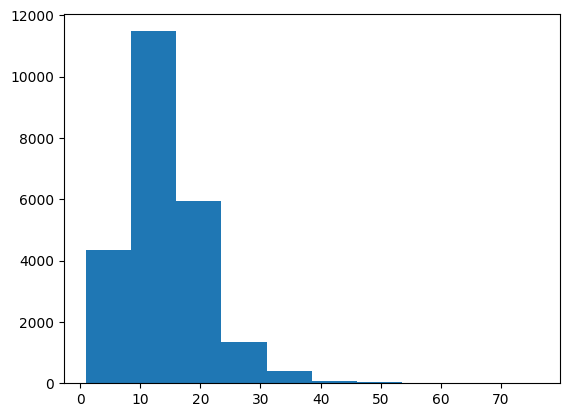

In [17]:
max_len_q = max(len(s) for s in q_texts)
print('max_len_q:', max_len_q)
max_len_a = max(len(s) for s in a_texts)
print('max_len_a:', max_len_a)

plt.hist([len(s) for s in all_texts])

In [18]:
MAX_LEN = 30

In [19]:
encoder_input = pad_sequences(q_sequences, maxlen=MAX_LEN, padding='pre')
encoder_input.shape, encoder_input[1500]

((11823, 30),
 array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,  162, 1680,  318, 2391,    2], dtype=int32))

In [20]:
decoder_input = pad_sequences(a_sequences_input, maxlen=MAX_LEN, padding='post')
decoder_input.shape, decoder_input[1500]

((11823, 30),
 array([   1, 1145,   33, 3040,   45,    4,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0], dtype=int32))

In [21]:
decoder_target = pad_sequences(a_sequences_target, maxlen=MAX_LEN, padding='post')
decoder_target.shape, decoder_target[1500]

((11823, 30),
 array([1145,   33, 3040,   45,    4,    2,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0], dtype=int32))

In [22]:
encoder_input_ = Input(shape=(MAX_LEN,), name='Encoder_Input')
embedding_encoder = Embedding(vocab_size + 1, EMBEDDING_DIM)
x = embedding_encoder(encoder_input_)
_, h, c = LSTM(LATENT_DIM, return_state=True)(x)
encoder_states = [h, c]
encoder_model = Model(encoder_input_, encoder_states)
encoder_model.summary()

2023-08-24 01:36:31.803690: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6638 MB memory:  -> device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:3f:00.0, compute capability: 7.5


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_Input (InputLayer)  [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 100)           500100    
                                                                 
 lstm (LSTM)                 [(None, 128),             117248    
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
Total params: 617348 (2.35 MB)
Trainable params: 617348 (2.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
decoder_input_ = Input(shape=(MAX_LEN,), name='Decoder_Input')
embedding_decoder = Embedding(vocab_size + 1, EMBEDDING_DIM)
x = embedding_decoder(decoder_input_)
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
decoder_output, _, _ = decoder_lstm(x, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax', name='Decoder_Output')
decoder_output = decoder_dense(decoder_output)
model_teacher_forcing = Model([encoder_input_, decoder_input_], decoder_output)
model_teacher_forcing.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_teacher_forcing.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Encoder_Input (InputLayer)  [(None, 30)]                 0         []                            
                                                                                                  
 Decoder_Input (InputLayer)  [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 100)              500100    ['Encoder_Input[0][0]']       
                                                                                                  
 embedding_1 (Embedding)     (None, 30, 100)              500100    ['Decoder_Input[0][0]']       
                                                                                            

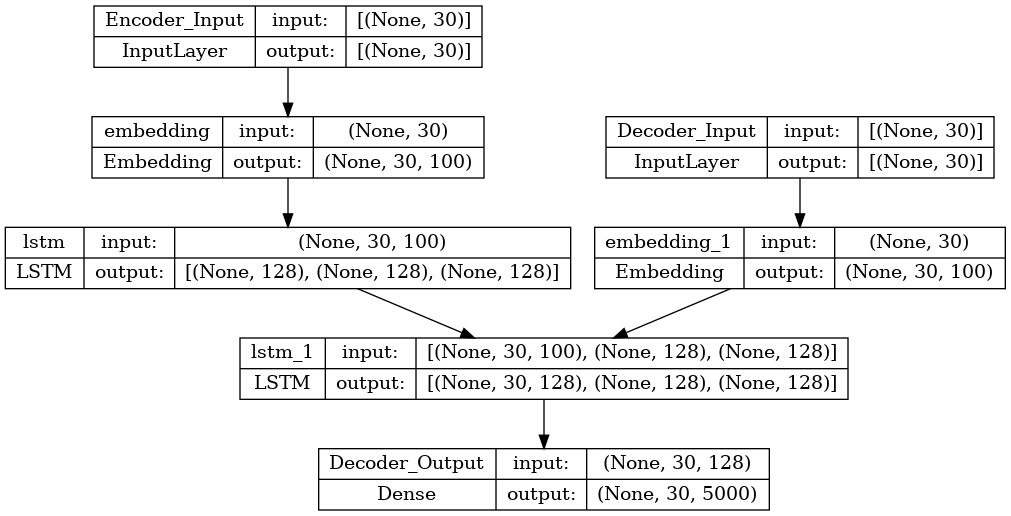

In [24]:
plot_model(model_teacher_forcing, show_shapes=True)

In [25]:
EPOCHS = 200
BATCH_SIZE = 64
history = model_teacher_forcing.fit(
    [encoder_input, decoder_input],
    decoder_target,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2
)

Epoch 1/200


2023-08-24 01:36:37.209573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-24 01:36:37.463886: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ecb3c9ef00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-24 01:36:37.463957: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-08-24 01:36:37.477227: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-24 01:36:37.644919: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


148/148 [==============================] - 29s 160ms/step - loss: 2.7146 - accuracy: 0.7300 - val_loss: 1.9975 - val_accuracy: 0.7007
Epoch 2/200
148/148 [==============================] - 8s 56ms/step - loss: 1.5047 - accuracy: 0.7817 - val_loss: 1.7741 - val_accuracy: 0.7585
Epoch 3/200
148/148 [==============================] - 6s 43ms/step - loss: 1.3836 - accuracy: 0.8018 - val_loss: 1.6956 - val_accuracy: 0.7624
Epoch 4/200
148/148 [==============================] - 6s 39ms/step - loss: 1.3266 - accuracy: 0.8056 - val_loss: 1.6634 - val_accuracy: 0.7666
Epoch 5/200
148/148 [==============================] - 5s 32ms/step - loss: 1.2891 - accuracy: 0.8098 - val_loss: 1.6424 - val_accuracy: 0.7699
Epoch 6/200
148/148 [==============================] - 5s 33ms/step - loss: 1.2598 - accuracy: 0.8123 - val_loss: 1.6311 - val_accuracy: 0.7705
Epoch 7/200
148/148 [==============================] - 5s 32ms/step - loss: 1.2364 - accuracy: 0.8136 - val_loss: 1.6163 - val_accuracy: 0.7729
Ep

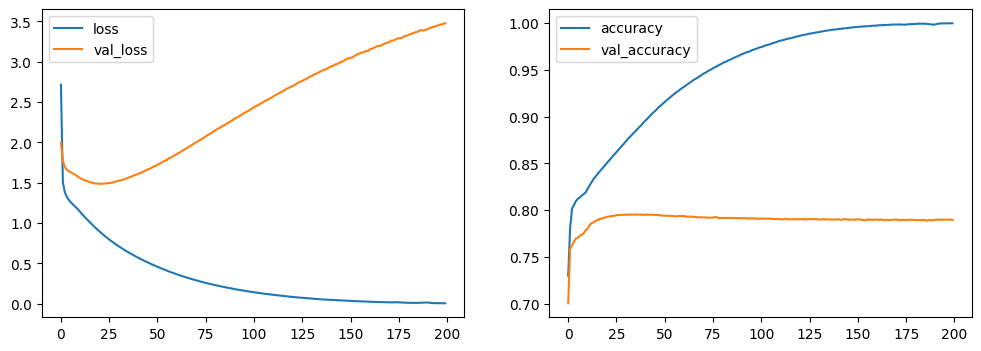

In [26]:
plt.figure(figsize=(12, 4))
for i, item in enumerate(['loss', 'accuracy']):
    plt.subplot(1, 2, i+1)
    plt.plot(history.history[item], label=item)
    plt.plot(history.history[f'val_{item}'], label=f'val_{item}')
    plt.legend()
plt.show()

In [27]:
model_teacher_forcing.save('data/s2s.h5')

/workspace/nlp/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
decoder_state_input_h = Input(shape=(LATENT_DIM,), name='Decoder_hidden')
decoder_state_input_c = Input(shape=(LATENT_DIM,), name='Decoder_cell')
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_input_single = Input(shape=(1,), name='Decoder_input')
x = embedding_decoder(decoder_input_single)
decoder_output, h, c = decoder_lstm(x, initial_state=decoder_state_inputs)
decoder_states = [h, c]
decoder_output = decoder_dense(decoder_output)
decoder_model = Model(
    [decoder_input_single] + decoder_state_inputs,
    [decoder_output] + decoder_states
)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Decoder_input (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     multiple                     500100    ['Decoder_input[0][0]']       
                                                                                                  
 Decoder_hidden (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 Decoder_cell (InputLayer)   [(None, 128)]                0         []                      

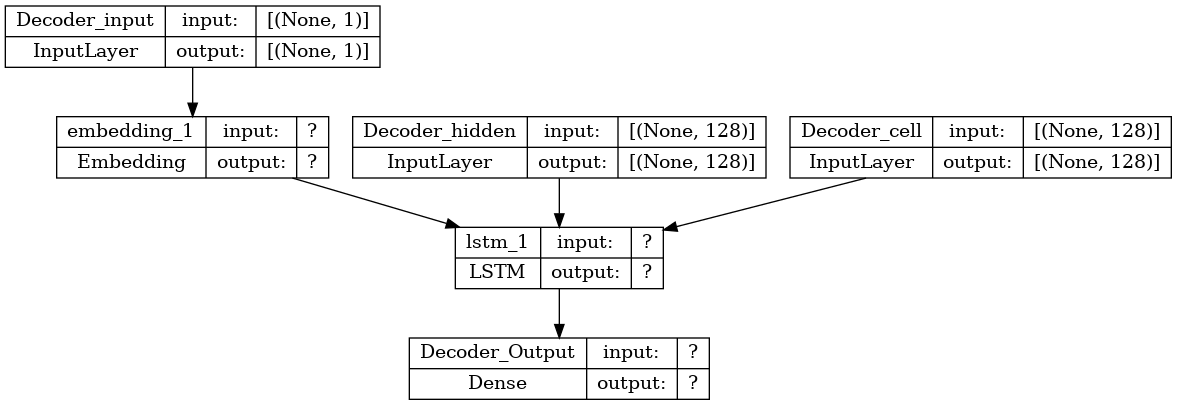

In [29]:
plot_model(decoder_model, show_shapes=True)

In [30]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq, verbose=0)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = bos_id
    eos = eos_id
    output_ids = []
    for _ in range(max_len_a):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)
        idx = np.argmax(output_tokens[0, 0, :])
        if idx == eos:
            break
        if idx > 0:
            output_ids.append(int(idx))
        target_seq[0, 0] = idx
        states_value = [h, c]
    return output_ids

In [31]:
sp.Load(f'data/{model_prefix}.model')
for _ in range(5):
    i = np.random.choice(len(q_texts))
    input_seq = encoder_input[i:i+1]
    response = decode_sequence(input_seq)
    print('-')
    print('q:', q_texts[i])
    print('a:', sp.DecodeIds(response))

-
q: 수업시간 내내 잤어
a: 한창 잠이 많을 때죠.
-
q: 어이 없는 헤어짐
a: 예상하지 못한 이별이었네요.
-
q: 커피 타기 귀찮아
a: 커피는 셀프였으면 좋겠어요.
-
q: 이별 성장통이 너무 길다.
a: 그만큼 많이 성장하려 하나봐요.
-
q: 짝녀 보란 듯이 성공하고 싶습니다.
a: 비움을 거라요.


In [32]:
while True:
    txt = input('q:')    
    if txt.lower() == 'quit':
        break
    print('q:', txt)
    input_seq = sp.encode_as_ids(txt)
    encoder_input = pad_sequences([input_seq], maxlen=MAX_LEN)
    answer = decode_sequence(encoder_input)
    print('a:', sp.DecodeIds(answer))

q: 다시 사랑한다 말할까?
a: 그럼요.
q: 사랑해!
a: 흔들리지 말아요.
q: 잘자!
a: 그걸 깨닫다니 대단하시군요.
